# Porównanie klasyfikatora konwolucyjnego i rekurencyjnego dla NLP

W tym notebooku porównamy działanie (architekturę, złożoność, efektywność uczenia) dwóch klasyfikatorów sentymentu recenzji

#### Załadujmy zależności

In [37]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

#### Ustawmy hiperparametry dla klasyfikatora konwolucyjnego

In [2]:
# lokalizacja wyjściowa dla wag:
conv_output_dir = 'model_output/conv'

# parametry treningu:
conv_epochs = 4
conv_batch_size = 128

# osadzenie przestrzeni wektorowej: 
conv_n_dim = 64
conv_n_unique_words = 5000 
conv_max_review_length = 400
conv_pad_type = trunc_type = 'pre'

#parametr dropoutu
conv_drop_embed = 0.2

# parametry architektury konwolucyjnej:
n_conv = 256 # filtry/kernele
k_conv = 3 # długość kernela

# parametry warstwy gęstej: 
n_dense = 256
dropout = 0.2

#### Ustawmy hiperparametry dla klasyfikatora rekurencyjnego

In [3]:
# lokalizacja wyjściowa dla wag:
rnn_output_dir = 'model_output/rnn'

# parametry treningu:
rnn_epochs = 16
rnn_batch_size = 128

# osadzenie przestrzeni wektorowej: 
rnn_n_dim = 64 
rnn_n_unique_words = 10000 
rnn_max_review_length = 100 #zmniejszone z powodu szybciej zanikającego gradientu w jednostkach rekurencyjnych
rnn_pad_type = trunc_type = 'pre'
rnn_drop_embed = 0.2 

# parametry architektury rekurencyjnej:
n_rnn = 256 
drop_rnn = 0.2

#### Załaduj dane treningowe i walidacyjne z parametrem liczby uwzględnianych słów (odrębnie dla obu klasyfikatorów)

In [4]:
(x_train_rnn, y_train_rnn), (x_val_rnn, y_val_rnn) = imdb.load_data(num_words=conv_n_unique_words)
(x_train_conv, y_train_conv), (x_val_conv, y_val_conv) = imdb.load_data(num_words=rnn_n_unique_words)

#### Przetwórz wszystkie załadowane dane poprzez ujednolicenie wielkości danych wejściowych

In [5]:
#dla rnn
x_train_rnn = pad_sequences(x_train_rnn, maxlen=rnn_max_review_length, padding=rnn_pad_type, truncating=trunc_type)
x_val_rnn = pad_sequences(x_val_rnn, maxlen=rnn_max_review_length, padding=rnn_pad_type, truncating=trunc_type)

In [6]:
# dla conv
x_train_conv = pad_sequences(x_train_conv, maxlen=conv_max_review_length, padding=conv_pad_type, truncating=trunc_type)
x_val_conv = pad_sequences(x_val_conv, maxlen=conv_max_review_length, padding=conv_pad_type, truncating=trunc_type)

#### Zaprojektuj obie architektury sieci, wybierając odpowiednie zaimportowane obiekty i zadeklarowane wyżej hiperparametry

#### ConvNN
- odpowiednio osadź przestrzeń wektorową (embedding), 
- dodaj przestrzenny dropout z odpowiednim parametrem i wybraną funkcją aktywacji
- utwórz warstwę konwolucyjną jednowymiarową z odpowiednimi hiperparametrami
- dodaj warstwę redukującą - globalny jednowymiarowy max-pooling
- uzupełnij sieć o warstwę gęstą z wybraną funkcją aktywacji i dropoutem
- zakończ warstwą klasyfikującą

In [7]:
model_conv = Sequential([
    Embedding(input_dim=conv_n_unique_words, output_dim=conv_n_dim, input_length=conv_max_review_length),
    SpatialDropout1D(conv_drop_embed),
    Conv1D(filters=n_conv, kernel_size=k_conv, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(n_dense, activation='relu'),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
])

In [8]:
model_conv.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 64)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 400, 256)          49408     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

#### RNN
- odpowiednio osadź przestrzeń wektorową (embedding), 
- dodaj przestrzenny dropout z odpowiednim parametrem i wybraną funkcją aktywacji
- utwórz prostą warstwę rekurencyjną z odpowiednimi hiperparametrami
- zakończ warstwą klasyfikującą

In [9]:
model_rnn = Sequential([
    Embedding(input_dim=rnn_n_unique_words, output_dim=rnn_n_dim, input_length=rnn_max_review_length),
    SpatialDropout1D(rnn_drop_embed),
    SimpleRNN(n_rnn, return_sequences=False, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [10]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 64)          0         
 lDropout1D)                                                     
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               82176     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


#### Skompiluj oba modele z odpowiednimi parametrami

In [11]:
# compile the model:
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Stwórz obiekty do rejestrowania wag dla każdego z modeli

In [12]:
# dla rnn
checkpoint_rnn = ModelCheckpoint(os.path.join(rnn_output_dir, 'rnn_weights.h5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
if not os.path.exists(rnn_output_dir):
    os.makedirs(rnn_output_dir)

In [13]:
# dla conv
checkpoint_conv = ModelCheckpoint(os.path.join(conv_output_dir, 'conv_weights.h5'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
if not os.path.exists(conv_output_dir):
    os.makedirs(conv_output_dir)

#### Naucz oba modele z użyciem zbiorów walidacyjnych, z odpowiednimi zadeklarowanymi wyżej parametrami

In [14]:
# rnn
history_rnn = model_rnn.fit(x_train_rnn, y_train_rnn, epochs=rnn_epochs, batch_size=rnn_batch_size, validation_data=(x_val_rnn, y_val_rnn), callbacks=[checkpoint_rnn])

Epoch 1/16
196/196 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.6090
Epoch 1: val_loss improved from inf to 0.52589, saving model to model_output/rnn/rnn_weights.h5
196/196 [==============================] - 23s 112ms/step - loss: 0.6637 - accuracy: 0.6090 - val_loss: 0.5259 - val_accuracy: 0.7521
Epoch 2/16
196/196 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.7794
Epoch 2: val_loss improved from 0.52589 to 0.48013, saving model to model_output/rnn/rnn_weights.h5
196/196 [==============================] - 22s 110ms/step - loss: 0.4809 - accuracy: 0.7794 - val_loss: 0.4801 - val_accuracy: 0.7777
Epoch 3/16
196/196 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.8237
Epoch 3: val_loss improved from 0.48013 to 0.38484, saving model to model_output/rnn/rnn_weights.h5
196/196 [==============================] - 22s 111ms/step - loss: 0.4030 - accuracy: 0.8237 - val_loss: 0.3848 - val_accuracy: 0.8366
Epoch 4/16
196

In [15]:
# conv
history_conv = model_conv.fit(x_train_conv, y_train_conv, epochs=conv_epochs, batch_size=conv_batch_size, validation_data=(x_val_conv, y_val_conv), callbacks=[checkpoint_conv])

Epoch 1/4
195/196 [============================>.] - ETA: 0s - loss: 0.4906 - accuracy: 0.7375
Epoch 1: val_loss improved from inf to 0.30624, saving model to model_output/conv/conv_weights.h5
196/196 [==============================] - 6s 19ms/step - loss: 0.4904 - accuracy: 0.7376 - val_loss: 0.3062 - val_accuracy: 0.8704
Epoch 2/4
193/196 [============================>.] - ETA: 0s - loss: 0.2463 - accuracy: 0.9003
Epoch 2: val_loss improved from 0.30624 to 0.25632, saving model to model_output/conv/conv_weights.h5
196/196 [==============================] - 4s 18ms/step - loss: 0.2464 - accuracy: 0.9004 - val_loss: 0.2563 - val_accuracy: 0.8950
Epoch 3/4
193/196 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9355
Epoch 3: val_loss did not improve from 0.25632
196/196 [==============================] - 4s 20ms/step - loss: 0.1702 - accuracy: 0.9354 - val_loss: 0.2644 - val_accuracy: 0.8940
Epoch 4/4
193/196 [============================>.] - ETA: 0s - loss: 0.1

#### Wykonaj inferencję (ewaluację) obu modeli uprzednio ładując wagi z ich najlepszych epok

In [17]:
model_conv.load_weights(os.path.join(conv_output_dir, 'conv_weights.h5'))
model_rnn.load_weights(os.path.join(rnn_output_dir, 'rnn_weights.h5'))

In [18]:
# predict
y_pred_conv = model_conv.predict(x_val_conv)
y_pred_rnn = model_rnn.predict(x_val_rnn)


#### Zestaw na jednym wykresie histogramy dla danych walidacyjnych obu modeli oraz, na kolejnym wykresie, krzywe ROC obu klasyfikatorów,  a następnie - patrząc na oba te wykresy oraz statystyki uczenia, zapisz trzy sensowne wnioski co do wyników

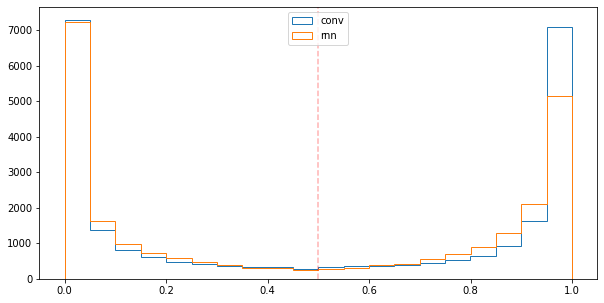

In [47]:
plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y_pred_conv, bins=20, label='conv', histtype='step', fill=False)
ax.hist(y_pred_rnn, bins=20, label='rnn', histtype='step', fill=False)
plt.axvline(x=0.5, alpha=0.3, color='r', ls='--')
ax.legend(loc='upper center')
plt.show()


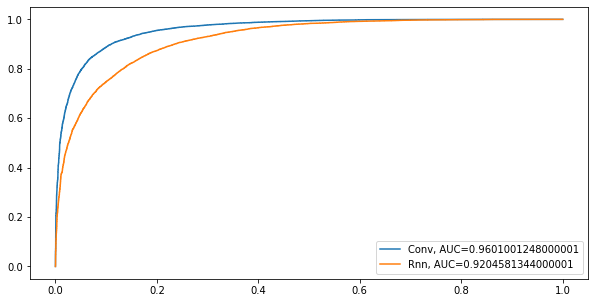

In [39]:
def plot_roc_auc(y_valid, y_pred, name):
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f"{name}, AUC="+str(roc_auc))

fig, ax = plt.subplots(figsize=(10, 5))
plot_roc_auc(y_val_conv, y_pred_conv, 'Conv')
plot_roc_auc(y_val_rnn, y_pred_rnn, 'Rnn')
ax.legend()
plt.show()


- Model konwolucyjny wykazywał większą pewność od modelu rekurencyjnego podczas klasyfikacji
- Model konwolucyjny osiągnął większą dokładność od modelu rekurencyjnego
- Oba modele szybko zaczęły się przeuczać